# Grocery Store Scarcity in Charlotte, North Carolina

## Table of Contents
1. [Introduction](#introduction)
2. [Data](#data)
3. [Methodology](#methodology)
4. [Analysis](#analysis)
5. [Results and Discussion](#results)
6. [Conclusion](#conclusion)
7. [References](#references)

## Introduction <a name="introduction"></a>

Food deserts are geographic areas where access to affordable, healthy food options is limited because grocery stores are too far away. According to the United States Department of Agriculture, 23.5 million Americans live in food deserts, and nearly half of them are also low-income. This limited access to grocery stores can lead to several long-term issues. Many people living in food deserts get meals from fast-food restaurants. Furthermore, food insecurity has a high correlation with increased diabetes rates. [5].  The lack of access to healthful foods can also contribute to other diet-related conditions, such as high blood pressure and cardiovascular disease [3]. 

The presence of food deserts has become both a public health and political issue in my hometown of Charlotte, North Carolina [2]. Food deserts are more prevalent among minority communities, and the detrimental consequences are exacerbated by a lack of transportation. 

In this project, we will attempt to **better understand which areas in Charlotte have limited access to grocery stores**. We will **use location data from the Foursquare Places API** to visualize the presence of grocery stores on maps. We will also use visualizations to **understand which areas in Charlotte could most benefit from new grocery store openings**. These results can be used by city planners and grocery store chains to prioritize grocery store openings in a way that **makes healthy food options accessible** to more (and, hopefully, all) Charlotteans. 

## Data <a name="data"></a>

Based on our project goals, we are interested in acquiring the following data. The source of the data is provided in parentheses:  

* Regions in Charlotte, NC. We decided to define regions by their ZIP code. (Map of Charlotte, NC) 
* Population data for Charlotte ZIP codes (worldpopulationreview.com)
* Grocery stores that are within a specified radius of each Charlotte ZIP code (**Foursquare Places API**) 
* Location data for each ZIP code in Charlotte and each grocery store (**geopy** geocoding services and **Foursquare Places API**) 

A description of the final data frame and features are provided in the below table: 

| Feature                       | Type   | Description                                                                                                                         |
| :-                            | :-     | :-          |
ZIP Code                        | string | Each of the ZIP codes within the Charlotte city limit. |
Latitude                        | float  | Latitude coordinate for each location. |
Longitude                       | float  | Longitude coordinate for each location. |
Population                      | int    | Count of residents within each ZIP code. |
Venue Count                     | int    | Count of grocery stores within a specified radius of the ZIP code center. |
Venue Scarcity                  | float  | Calculated field that indicates “For every *x* number of people, there is *1* grocery store. |
Grocery Store Relative Scarcity | float  | Max absolute scale of `Grocery Store Scarcity`. Each `Grocery Store Scarcity` value is divided by the maximum value. Range is 0.0 to 1.0. | 



#### Import Dependencies

First, let's install and import all the dependencies that we will need.

In [ ]:
# Un-comment these lines if you have not already downloaded the below libraries 
# !conda install -c conda-forge geopy --yes  
# !conda install -c conda-forge folium=0.5.0 --yes
# !pip install geocoder
# !conda install -c anaconda beautifulsoup4 --yes
print ('Libraries installed!')

In [2]:
import numpy as np  # library to handle data in a vectorized manner

import pandas as pd  # library for data analsysis

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json  # library to handle JSON files

from geopy.geocoders import Nominatim  # convert an address into latitude and longitude values
import geocoder 

import requests # library to handle requests
from pandas.io.json import json_normalize  # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

import folium  # map rendering library

from bs4 import BeautifulSoup  # for HTML parsing 

print('Libraries imported!')

Libraries imported!


#### Create Data Frames 

Next, let's create a pandas data frame with the ZIP codes in Charlotte, North Carolina. 

In [3]:
df_zip = pd.DataFrame(columns =['ZIP Code', 'Latitude', 'Longitude'] )
# Charlotte center-city ZIP codes
df_zip['ZIP Code'] = [28202, 28204, 28203, 28206, 
                      28205, 28209, 28208, 28031, 
                      28036, 28078, 28214, 28216, 
                      28269, 28262, 28278, 28208, 
                      28213, 28217, 28273, 28215, 
                      28134, 28210, 28211, 28212,
                      28227, 28277, 28226, 28270,
                      28105]

Let's also enter the latitude and longitude data for each of these ZIP codes into the dataframe. 

In [4]:
geolocator = Nominatim(user_agent="charlotte_explorer")

# Get Charlotte, NC latitude and longitude 
address = 'Charlotte, NC'
location = geolocator.geocode(address)
lat_char = location.latitude
lon_char = location.longitude 

for z, i in zip(df_zip['ZIP Code'], range(0, len(df_zip))): 
    address = str(z) + ", NC"
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    df_zip['Latitude'][i] = latitude
    df_zip['Longitude'][i] = longitude

# Observe the data frame 
df_zip

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


,ZIP Code,Latitude,Longitude
0,28202,35.2276,-80.8421
1,28204,35.217,-80.8278
2,28203,35.2116,-80.8568
3,28206,35.2469,-80.829
4,28205,35.2205,-80.7886
5,28209,35.183,-80.8569
6,28208,35.2328,-80.8983
7,28031,35.4707,-80.8814
8,28036,35.5053,-80.8078
9,28078,35.409,-80.8646


We will also import a data frame that has North Carolina population by ZIP code, and use a *left join* to merge the `df_zip` data frame and this new data frame. This population data was acquired from WorldPopulationReview.com [4], and saved to my GitHub repository. 

In [5]:
# CSV is sourced from https://worldpopulationreview.com/zips/north-carolina
url = 'https://raw.githubusercontent.com/sakibkbhuiyan/CourseraDataScienceCapstone/ba42c11eef9aed05555931dbd547626d0f7e3b4e/CSV_PopulationData.csv'
df_pop = pd.read_csv(url)
df_pop.columns = ['ZIP Code', 'City', 'County', 'Population']

# Observe the data frame 
df_pop.head()

,ZIP Code,City,County,Population
0,27610,Raleigh,Wake,79924
1,28269,Charlotte,Mecklenburg,77248
2,28277,Charlotte,Mecklenburg,72132
3,28027,Concord,Cabarrus,68716
4,27587,Wake Forest,Wake,68491


In [6]:
# Merge the two data frames using a left join and select specific columns 
columns = ['ZIP Code', 'Latitude', 'Longitude', 'Population']
df_zip = pd.merge(left = df_zip, right = df_pop, how = 'left', on = 'ZIP Code')[columns]
df_zip.head()

,ZIP Code,Latitude,Longitude,Population
0,28202,35.2276,-80.8421,13498
1,28204,35.217,-80.8278,7199
2,28203,35.2116,-80.8568,16655
3,28206,35.2469,-80.829,12036
4,28205,35.2205,-80.7886,48798


#### Map of Charlotte 

Let's visualize the center of each ZIP code on the map. In the below map, the size of the markers is proporational to the size of the ZIP code's population. Larger markers indicate a larger population within that specific ZIP code. 

In [7]:
# Create map of Charlotte using latitude and longitude values
map_charlotte = folium.Map(location=[lat_char, lon_char], zoom_start=10)

max_pop = max(df_zip.Population)

# Add ZIP Codemarkers to map
for lat, lng, z, pop in zip(df_zip['Latitude'], df_zip['Longitude'], df_zip['ZIP Code'], df_zip['Population']):
    label = '{}'.format(z)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=(15*pop/max_pop),  # marker size is proportional to the Population 
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_charlotte)  
    
map_charlotte

#### Foursquare Places API Data 

Let's define our Foursquare Places API credentials and create a function to get nearby venues for all of the ZIP codes. We will search for `'grocery store'` within a 1-mile radius of the ZIP code center. 

In [8]:
CLIENT_ID = 'your-client-id' # your Foursquare ID
CLIENT_SECRET = 'your-client-secret' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 50 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: RT22KWRIQYABLI1VZ4CEHN4ZDVSMWR311VVA4XJ0N5R2Q5WL
CLIENT_SECRET:IJCWHNSU0P2EOOUHPNRGRIMAWUUSOD0LPB1QRC4CREGUL10Y


In [9]:
# Variables to control the search radius
miles = 1
radius_meter = miles*1609  # 1,609 meters in 1 mile 

# Variable to control what type of venue to search for 
in_query = 'grocery store'

def getNearbyVenues(names, latitudes, longitudes, radius=radius_meter, query = in_query):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        url = 'https://api.foursquare.com/v2/venues/explore'
        params = dict(
            client_id = CLIENT_ID,
            client_secret = CLIENT_SECRET,
            v = VERSION,
            ll='{},{}'.format(lat, lng),
            query= in_query,
            limit = LIMIT
        )
        
        # Make the GET request
        results = requests.get(url, params = params).json()["response"]['groups'][0]['items']
        
        # Return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['ZIP Code', 
                  'ZIP Code Latitude', 
                  'ZIP Code Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [10]:
# Use the above function to retreive venues for all ZIP codes 
df_char_venues = getNearbyVenues(names = df_zip['ZIP Code'], 
                                latitudes = df_zip['Latitude'], 
                                longitudes = df_zip['Longitude'], 
                                )

In [11]:
# Observe the data frame
print(df_char_venues.shape)
df_char_venues.head()

(1241, 7)


,ZIP Code,ZIP Code Latitude,ZIP Code Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,28202,35.227552,-80.842109,Harris Teeter,35.231231,-80.843956,Supermarket
1,28202,35.227552,-80.842109,Whole Foods Market,35.221301,-80.846211,Grocery Store
2,28202,35.227552,-80.842109,Trader Joe's,35.211608,-80.835468,Grocery Store
3,28202,35.227552,-80.842109,Target,35.214366,-80.834270,Big Box Store
4,28202,35.227552,-80.842109,Berrybrook Farm,35.202310,-80.844790,Grocery Store


#### Grocery Store Density 

Now that we have grocery store venue data and population data, let's try to get a better understanding of the density of grocery stores and how they compare to the population in each ZIP code. Specifically, let's create a `Scarcity` feature that can be interpreted as “Each grocery store within this ZIP code serves ‘x’ people.” The higher this `Scarcity` value, the more people that 1 grocery store is serving. This suggests that ZIP codes with high `Scarcity` values have a low density of grocery stores within the area, and there may not be enough grocery stores to adequately serve the population within the ZIP code. 

We can start by getting a count of how many grocery stores were returned within a 1-mile radius of each ZIP code. Then, let's merge this grocery store count data with the `df_zip` data frame. 

In [12]:
# Get the count of grocery store venues for each ZIP code 
df_venue_count = df_char_venues['ZIP Code'].value_counts().reset_index().rename(columns = {'index': 'ZIP Code', 'ZIP Code': 'Venue Count'})

# Merge venue count data with df_zip 
df_zip = pd.merge(left = df_zip, right = df_venue_count, how = 'left', on = 'ZIP Code')

# Calculate a new feature that answers 'For every "x" number of people, there is 1 grocery store.'
df_zip['Venue Scarcity'] = df_zip['Population']/df_zip['Venue Count']
df_zip['Relative Scarcity'] = df_zip['Venue Scarcity']/max(df_zip['Venue Scarcity'])

# Observe the data frame
df_zip

,ZIP Code,Latitude,Longitude,Population,Venue Count,Venue Scarcity,Relative Scarcity
0,28202,35.2276,-80.8421,13498,14,964.142857,0.515089
1,28204,35.217,-80.8278,7199,20,359.950000,0.192302
2,28203,35.2116,-80.8568,16655,20,832.750000,0.444893
3,28206,35.2469,-80.829,12036,39,308.615385,0.164876
4,28205,35.2205,-80.7886,48798,50,975.960000,0.521402
5,28209,35.183,-80.8569,23533,38,619.289474,0.330852
6,28208,35.2328,-80.8983,40284,80,503.550000,0.269019
7,28031,35.4707,-80.8814,28077,15,1871.800000,1.000000
8,28036,35.5053,-80.8078,18266,50,365.320000,0.195170
9,28078,35.409,-80.8646,61043,49,1245.775510,0.665549


## Methodology <a name = "methodology"></a>

In this project, we directed our efforts on detecting areas in Charlotte that have a low **grocery store density**. We limited our analysis to a 1-mile (1.6-kilometer) radius around the center of each ZIP code. 

First, we aggregated all of the data that was needed from the various sources. We used Charlotte ZIP codes and retrieved population data for each ZIP code from WorldPopulationReview.com. We also used the Foursquare Places API to search for grocery stores within a 1-mile radius. We used a map to visualize the distribution of grocery stores across Charlotte. 

We then created some calculated fields to understand the **grocery store density** for each of the zip codes. Specifically, we created a new feature called `Grocery Store Scarcity`. The value of this feature can be interpreted as “Each grocery store within this ZIP code serves ‘x’ people.” The higher this grocery scarcity values, the more people that 1 grocery store is serving. This suggests that ZIP codes with high `Grocery Store Scarcity` values have a low density of grocery stores within the area, and there may not be enough grocery stores to adequately serve the population within the ZIP code. 

We used these new calculated fields to identify the ZIP codes that have low grocery store density (high `Grocery Store Scarcity`) and high grocery store density (low `Grocery Store Scarcity`). 

Finally, we created visualizations to better understand the data. We used boxplots to understand the distribution of `Population` and `Grocery Store Scarcity`. We used a two-axis bar plot to compare the ‘Population’ of each ZIP code to its ‘Grocery Store Scarcity’. This helped illuminate which ZIP codes had an imbalance between their population and their prevalence of grocery stores. This information can be used to determine which ZIP codes are most in need of additional grocery stores. We also visualized `Population` and `Grocery Store Scarcity` using mapping tools. 


## Analysis <a name = "analysis"></a> 

#### Map of Charlotte Grocery Stores 

Now that we have all grocery stores within a 1-mile radius of each ZIP code, lets visualize these grocery stores on the map. Just in the map above, the blue markers represent the ZIP code centers and the size of the blue markers is proportional to the `Population` of the ZIP code. The red markers are grocery stores, and we can see that there are certainly some areas with a much higher density of grocery store prevalence than other areas. 

In [13]:
# Create map of Charlotte using latitude and longitude values
map_charlotte = folium.Map(location=[lat_char, lon_char], zoom_start=10)

max_pop = max(df_zip.Population)

# Add ZIP code markers to map
for lat, lng, z, pop in zip(df_zip['Latitude'], df_zip['Longitude'], df_zip['ZIP Code'], df_zip['Population']):
    label = '{}'.format(z)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=(15*pop/max_pop),  # marker size is proportional to the Population 
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_charlotte)
    
# Add grocery stores to map 
for lat, lng, venue, category in zip(df_char_venues['Venue Latitude'], df_char_venues['Venue Longitude'], df_char_venues['Venue'], df_char_venues['Venue Category']): 
    label = '{} ({})'.format(venue, category)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius= 1,   
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.5,
        parse_html=False).add_to(map_charlotte)
    
map_charlotte

Next, let's take a look at the ZIP codes with the highest and lowest values for `Venue Scarcity`. ZIP codes with a high value of `Venue Scarcity` have fewer grocery stores relative to their population. 

For example, ZIP code 28202 has a `Grocery Store Scarcity` of approximately **964**. This means that for every **964** people that live in *28202*, there is 1 grocery store. In contrast, for every **364** people that live in *28204*, there is 1 grocery store. 

Here are the ZIP codes that have the top 5 `Grocery Store Scarcity` values. These are the ZIP codes that may not have enough grocery stores to adequately serve their populations. Opening additional grocery stores here could help reduce the food desert problem.  

In [14]:
df_zip.sort_values(by = 'Venue Scarcity', ascending = False)[['ZIP Code', 'Population', 'Venue Scarcity']].head()

,ZIP Code,Population,Venue Scarcity
7,28031,28077,1871.800000
13,28262,43209,1800.375000
25,28277,72132,1717.428571
12,28269,77248,1544.960000
19,28215,62543,1250.860000


And here are the ZIP codes that have the bottom 5 `Grocery Store Scarcity` values: 

In [15]:
df_zip.sort_values(by = 'Venue Scarcity', ascending = False)[['ZIP Code', 'Population', 'Venue Scarcity']].tail()

,ZIP Code,Population,Venue Scarcity
6,28208,40284,503.550000
8,28036,18266,365.320000
1,28204,7199,359.950000
3,28206,12036,308.615385
20,28134,11037,220.740000


#### Visualize the Data

Now that we have a better understanding of which areas have the greatest scarcity in grocery stores, let's visualize the data. 

First, let's use a bar plot to compare each ZIP code's `Population` to its `Venue Scarcity`. 

In [16]:
columns = ['ZIP Code', 'Latitude', 'Longitude', 'Population', 'Venue Count', 'Venue Scarcity', 'Relative Scarcity']
df_zip_sort = df_zip.sort_values('Population', ascending = False)[columns]

# Observe the data frame 
df_zip_sort.head()

,ZIP Code,Latitude,Longitude,Population,Venue Count,Venue Scarcity,Relative Scarcity
12,28269,35.3298,-80.8038,77248,50,1544.960000,0.825387
25,28277,35.0544,-80.8195,72132,42,1717.428571,0.917528
19,28215,35.2466,-80.7097,62543,50,1250.860000,0.668266
9,28078,35.409,-80.8646,61043,49,1245.775510,0.665549
24,28227,35.1842,-80.6824,57336,50,1146.720000,0.612630


In the below bar plot, the ZIP codes are arranged in order of decreasing `Population` (blue bars from left to right). For example, 28269 has the highest population, while 28204 has the lowest population. 

The orange bars represent the `Grocery Store Scarcity`. We can easily see an imbalance between the two bars for several ZIP codes. Most notably, we see that the `Grocery Store Scarcity` is **much higher** than the `Population` for the following ZIP codes: 

* **28262**
* **28031**
* **28203**
* **28202**
* **28204**

This suggests that these ZIP codes may not have enough grocery stores to adequately serve their populations, and **opening additional grocery stores in these ZIP codes would be the most beneficial for their residents.** 

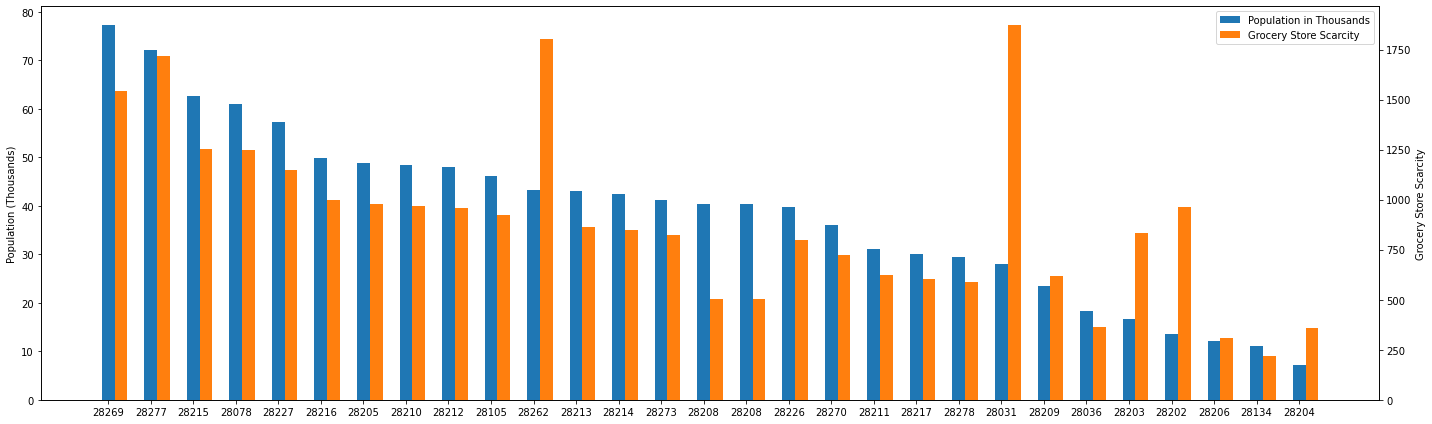

In [17]:
plt.rcParams["figure.figsize"] = (20,6)
x = np.arange(len(df_zip_sort))
fig, ax1 = plt.subplots()
w = 0.3 

# plt.xticks() will label the bars on the x-axis with the ZIP code labels 
plt.xticks(x , df_zip_sort['ZIP Code'])

# First set of bars for population (left axis)
pop = ax1.bar(x, df_zip_sort['Population']/1000, width = w, color = 'tab:blue', align = 'center')
plt.ylabel('Population (Thousands)')  # set the y-axis label

# Use two different axes that share the same x-axis 
ax2 = ax1.twinx()

# Second set of bars for Venue Density (right axis )
ven = ax2.bar((x+0.3), df_zip_sort['Venue Scarcity'], width = w, color = 'tab:orange', align = 'center')
plt.ylabel('Grocery Store Scarcity')   # set the y-axis label

# Set the legend
plt.legend([pop, ven], ['Population in Thousands', 'Grocery Store Scarcity'])

fig.tight_layout()

plt.show()

Let's also look at the distribution of `Population` and `Venue Scarcity` using boxplots. In the boxplots below, we see that the top 3 `Grocery Store Scarcity` values are, indeed, outliers. As we saw in the above sorted data frames, these correspond to ZIP codes **28031**, **28262**, and **28277**. Each of these zip codes are in the outermost perimeter of the Charlotte city border, **which could suggest that outer-perimeter ZIP codes are more likely to be food deserts than center-city ZIP codes.** 

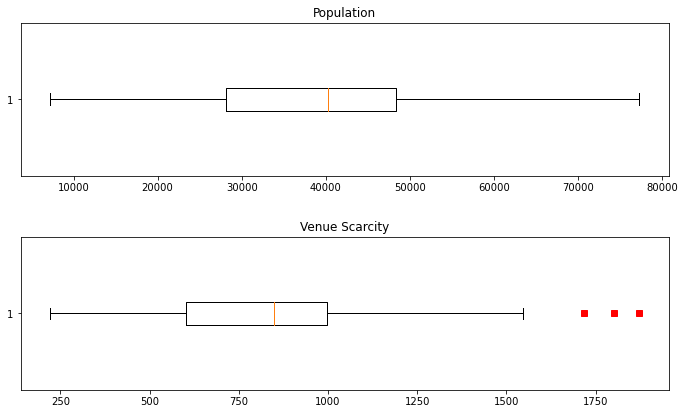

In [18]:
plt.rcParams["figure.figsize"] = (10,6)
np.random.seed(1234)
fig, axs = plt.subplots(2, 1)

axs[0].boxplot(df_zip['Population'], 0, 'rs', 0)
axs[0].set_title('Population')

axs[1].boxplot(df_zip['Venue Scarcity'],  0, 'rs', 0)
axs[1].set_title('Venue Scarcity')

fig.subplots_adjust(left=0.08, right=0.98, bottom=0.05, top=0.9,
                    hspace=0.4, wspace=0.3)

plt.show()

Finally, let's visualize the `Population` and `Grocery Store Scarcity` on a map. In the below map, the blue-filled markers indicate the ZIP code centers, and the size of each marker is proportional to the `Population`. And the size of the purple-outlined markers is proporational to the `Grocery Store Scarcity`. 

For ZIP codes that have a purple marker larger than the blue marker, there may be a lack of enough grocery stores in the area. We see that the most obvious ZIP codes where this is true are **28031** and **28262**. 

In [19]:
# Create map of Charlotte using latitude and longitude values
map_charlotte = folium.Map(location=[lat_char, lon_char], zoom_start=10)

max_pop = max(df_zip.Population)

# Add ZIP code markers to map
for lat, lng, z, pop in zip(df_zip['Latitude'], df_zip['Longitude'], df_zip['ZIP Code'], df_zip['Population']):
    label = '{}'.format(z)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=(15*pop/max_pop),  # marker size is proportional to the Population 
        popup=label,
        color='lightskyblue',
        fill=True,
        fill_color='lightskyblue',
        fill_opacity=0.7,
        parse_html=False).add_to(map_charlotte)
    
# Add Relative Scarcity to map 
for lat, lng, scarcity in zip(df_zip['Latitude'], df_zip['Longitude'], df_zip['Relative Scarcity']): 
    label = '{}'.format(scarcity)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius= 15*scarcity,  # marker size is proportional to the Relative Scarcity 
        popup=label,
        color='blueviolet',
        fill=False,
        parse_html=False).add_to(map_charlotte)
    
map_charlotte

## Results and Discussion <a name = "results"></a>

Our analysis shows that there are, indeed, certain ZIP codes in Charlotte that have an imbalance between their population and the density of grocery stores. These ZIP codes could potentially be food deserts, and our analysis suggests that opening additional grocery stores in these specific areas could have a larger impact than opening additional grocery stores in other ZIP codes. 

We found that the lack of grocery stores is most prevalent in ZIP codes **28262** and **28031**. Interestingly, these ZIP codes are found along the perimeter of the Charlotte city limits. This suggests that food deserts may be more prevalent outside of the city center.  

#### Future Expansion Potential 
To dig deeper into the issue of food deserts in Charlotte, future work would require more data to additional features for each zip code. A few suggestions for future work are below: 

* Include income data for each ZIP code. This could help explain whether grocery stores are more prevalent in affluent areas because retailers believe their revenue will be higher in these areas. 
* Include demographics (race, age, education) for each ZIP code. This could help explain whether food deserts disproportionately affect certain demographics, and whether retailers should be incentivized to open grocery stores in specific under-served areas. 
* Use clustering with income and demographic data to understand which ZIP codes are the most similar. 


## Conclusion <a name = "conclusion"></a>

In this project, we found that there are, indeed, certain areas in Charlotte, North Carolina, that have a low density of grocery stores. These areas could potentially be food desserts, and city government officials should prioritize these areas. Our analysis could be used by city officials to determine which areas in Charlotte are most in need of additional grocery stores. This insight can be used to incentivize retailers to open new grocery stores in targeted areas, through financing, tax breaks, and other financial incentives. 

Future work with additional data (e.g., income and demographic data) could also help city officials, public health practitioners, and activists determine whether the inequity in grocery store access is related to additional factors. This type of work is essential to take quick action and eliminate food desserts in cities across the United States. 


## References <a name="references"></a>

1. Charlotte Zip Code Map: https://www.usmapguide.com/north-carolina/charlotte-zip-code-map/
2. Grocery deserts still exist in Charlotte: https://charlotte.axios.com/239626/grocery-deserts-still-exist-in-charlotte-heres-whats-being-done-to-get-help-fix-the-problem/
3. What are food deserts, and how do they impact health?: https://www.medicalnewstoday.com/articles/what-are-food-deserts
4. World Population Review: https://worldpopulationreview.com/zips/north-carolina
5. 11 Facts About Food Deserts: https://www.dosomething.org/us/facts/11-facts-about-food-deserts